## Preambule

In [1]:
# General packages
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import xarray as xr
from matplotlib import colors
import json

# Plotting
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.colors import n_colors

## Paths

In [2]:
path_data = Path("K:/Data/Data_EffortSharing/DataUpdate_ongoing/")

## Read data files

In [3]:
xr_dataread = xr.open_dataset(path_data / "startyear_2021/xr_dataread.nc")
all_regions_iso = np.load(path_data / "all_regions.npy")
all_regions_names = np.load(path_data / "all_regions_names.npy")
all_countries_iso = np.load(path_data / "all_countries.npy", allow_pickle=True)
all_countries_names = np.load(path_data / "all_countries_names.npy", allow_pickle=True)

In [4]:
df = pd.read_excel(Path("X:/user/dekkerm/Data/") / "UNFCCC_Parties_Groups_noeu.xlsx", sheet_name = "Country groups")
countries_iso2 = np.array(df["Country ISO Code"])
group_ldc = countries_iso2[np.array(df["LDC"]) == 1]
group_hdc = countries_iso2[np.array(df["HICO"]) == 1]

In [5]:
df = pd.read_excel("X:/user/dekkerm/Data/UNFCCC_Parties_Groups_noeu.xlsx", sheet_name = "Country groups")
countries_iso = np.array(df["Country ISO Code"])
group_cvf = countries_iso[np.array(df["CVF (24/10/22)"]) == 1]
group_g20 = countries_iso[np.array(df["G20"]) == 1]
group_eu = countries_iso[np.array(df["EU"]) == 1]
group_g7 = countries_iso[np.array(df["G7"]) == 1]
group_na = countries_iso[np.array(df["Northern America"]) == 1]
group_um = countries_iso[np.array(df["Umbrella"]) == 1]
group_au = countries_iso[np.array(df["Australasia"]) == 1]
group_af = countries_iso[np.array(df["African Group"]) == 1]
group_sids = countries_iso[np.array(df["SIDS"]) == 1]
xr_alloc_2030 = xr.open_dataset(path_data / "startyear_2021/Aggregated_files/xr_alloc_2030_GHG_incl.nc")
xr_alloc_2040 = xr.open_dataset(path_data / "startyear_2021/Aggregated_files/xr_alloc_2040_GHG_incl.nc")
group_ldc = countries_iso[np.array(df["LDC"]) == 1]
group_eg = countries_iso[np.array(df["European Group"]) == 1]

In [6]:
xr_allocs = {}
for cty in ['EU', 'USA', 'IND', 'CHN', 'BRA', 'ZAF']:
    xr_allocs[cty] = xr.open_dataset(path_data / "startyear_2021" / "Allocations_GHG_incl" / ("xr_alloc_"+cty+".nc"))

## Figure illustration

In [7]:
settings_specific = {'Temperature': 1.6,
                    'Risk': 0.5,
                    'NegEmis': 0.5,
                    'NonCO2red': 0.5,
                    'Timing': "Immediate",
                    'Convergence_year': 2050,
                   'Scenario': 'SSP2',
                   'Discount_factor': 0,
                   'Historical_startyear': 1990,
                   'Capability_threshold': "Th",
                   'RCI_weight': "Half"}

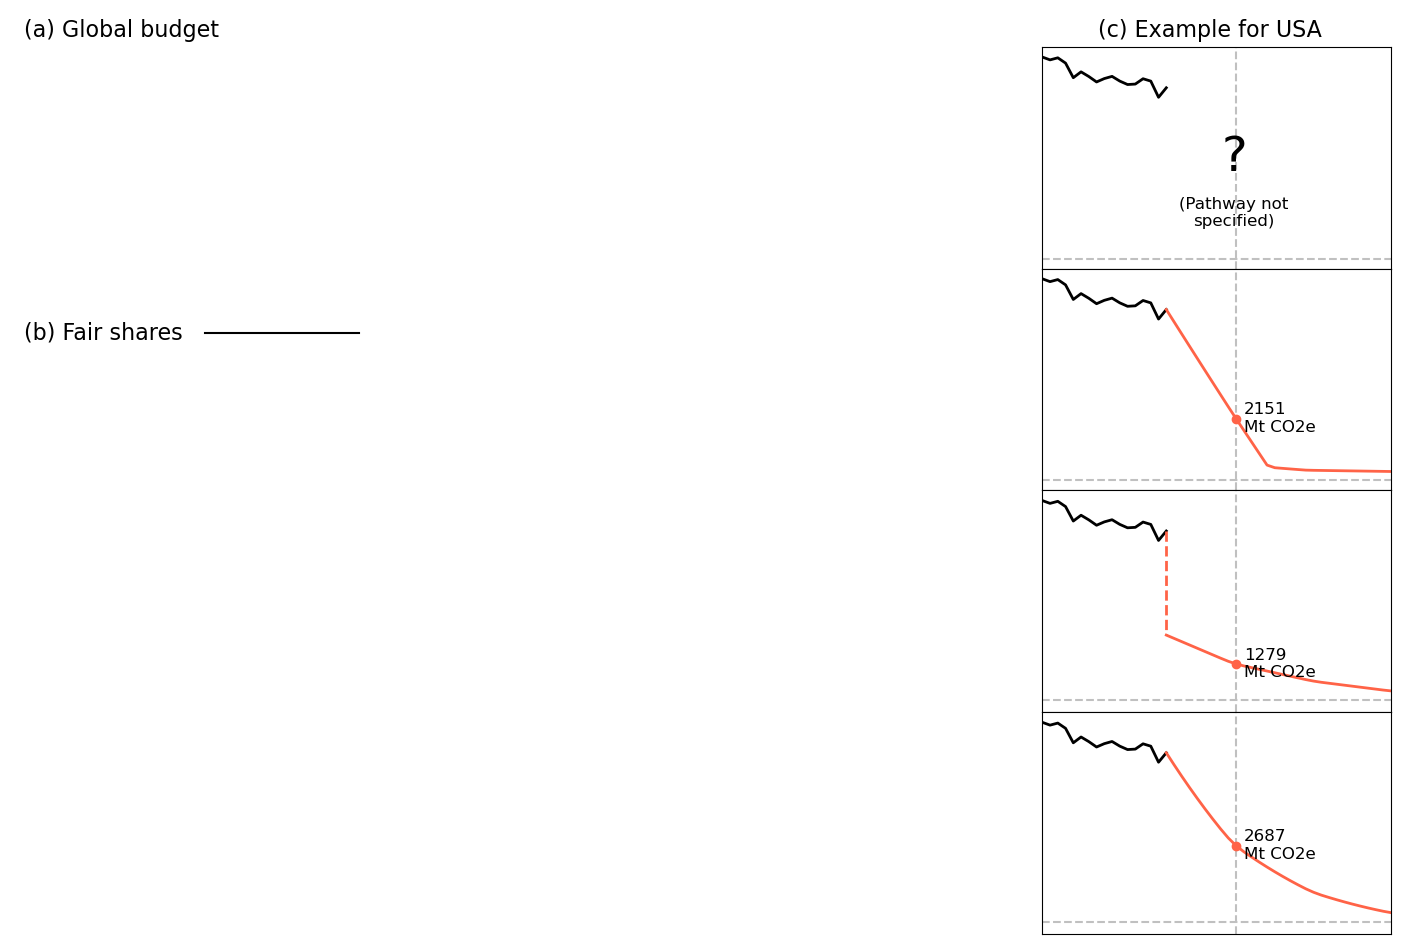

In [8]:
input_region = 'USA'

fig, ax = plt.subplots(1, 1, figsize=(18, 12), gridspec_kw={'wspace': 0, 'hspace': 0})

for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# Panel A
ax.text(
    0.01, 0.99, '(a) Global budget',
    transform=ax.transAxes,  # Use Axes coordinates (0=left, 1=right for x; 0=bottom, 1=top for y)
    fontsize=16,
    verticalalignment='top', 
    horizontalalignment='left'
)

# Panel B
ax.text(
    0.01, 0.65, '(b) Fair shares',
    transform=ax.transAxes,  # Use Axes coordinates (0=left, 1=right for x; 0=bottom, 1=top for y)
    fontsize=16,
    verticalalignment='center', 
    horizontalalignment='left'
)
ax.plot([0.14, 0.25], [0.65, 0.65], 'k')

# Panel C
ax.text(
    0.86, 0.99, '(c) Example for '+input_region,
    transform=ax.transAxes,  # Use Axes coordinates (0=left, 1=right for x; 0=bottom, 1=top for y)
    fontsize=16,
    verticalalignment='top', 
    horizontalalignment='center'
)
for i in range(4):

    inset_ax = ax.inset_axes([0.74, 0.72-0.24*i, 0.25, 0.24])
    
    hist = xr_dataread.GHG_hist.sel(Region=input_region).sel(Time=np.arange(2005, 2022))
    inset_ax.plot(hist.Time, hist, lw=2, color='black')
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])
    inset_ax.set_xlim([2005, 2050])
    inset_ax.axvline(x=2030, color='silver', linestyle='--')
    inset_ax.axhline(y=0, color='silver', linestyle='--')

    if i == 0:
        inset_ax.text(
            0.55, 0.5, '?',
            transform=inset_ax.transAxes,  # Use Axes coordinates (0=left, 1=right for x; 0=bottom, 1=top for y)
            fontsize=35,
            verticalalignment='center', 
            horizontalalignment='center'
        )
        inset_ax.text(
            0.55, 0.25, '(Pathway not\nspecified)',
            transform=inset_ax.transAxes,  # Use Axes coordinates (0=left, 1=right for x; 0=bottom, 1=top for y)
            fontsize=12,
            verticalalignment='center', 
            horizontalalignment='center'
        )


    if i >= 1:
        alloc = [xr_allocs[input_region].sel(**settings_specific)['PCB_lin'],
                 xr_allocs[input_region].sel(**settings_specific)['PC'],
                 xr_allocs[input_region].sel(**settings_specific)['PCC']][i-1]
        inset_ax.plot(alloc.Time, alloc, lw=2, color='tomato')
        if i == 2: inset_ax.plot([2021, 2021], [hist.sel(Time=2021), alloc.sel(Time=2021)], '--', lw=2, color='tomato')
        inset_ax.plot([2030], [alloc.sel(Time=2030)], 'o', lw=2, color='tomato')
        #red = 1-alloc / hist.sel(Time=2015)
        inset_ax.text(2031, alloc.sel(Time=2030), str(int(float(alloc.sel(Time=2030))))+'\nMt CO2e', color='black', verticalalignment='center', fontsize=12)



In [9]:
alloc

<xarray.DataArray 'PCC' (Time: 80)> Size: 320B
array([ 5.951855e+03,  5.531629e+03,  5.124138e+03,  4.729384e+03,
        4.347365e+03,  3.978082e+03,  3.621536e+03,  3.277725e+03,
        2.956468e+03,  2.687771e+03,  2.473121e+03,  2.287025e+03,
        2.107538e+03,  1.934662e+03,  1.768396e+03,  1.608740e+03,
        1.455694e+03,  1.309259e+03,  1.169434e+03,  1.048091e+03,
        9.482513e+02,  8.640510e+02,  7.836180e+02,  7.069520e+02,
        6.340533e+02,  5.649218e+02,  4.995574e+02,  4.379602e+02,
        3.801301e+02,  3.310290e+02,  3.091257e+02,  2.921842e+02,
        2.752427e+02,  2.583012e+02,  2.413597e+02,  2.244182e+02,
        2.074767e+02,  1.905352e+02,  1.735938e+02,  1.593408e+02,
        1.481517e+02,  1.396512e+02,  1.311507e+02,  1.226502e+02,
        1.141497e+02,  1.056491e+02,  9.714863e+01,  8.864811e+01,
        8.014760e+01,  7.248818e+01,  6.597121e+01,  6.029535e+01,
        5.461948e+01,  4.894361e+01,  4.326775e+01,  3.759188e+01,
        3.191601e+01,  2.624015e+01,  2.056428e+01,  1.533517e+01,
        1.050417e+01,  6.119928e+00,  1.735685e+00, -2.648558e+00,
       -7.032802e+00, -1.141705e+01, -1.580129e+01, -2.018553e+01,
       -2.456978e+01, -2.865269e+01, -3.252520e+01, -3.609638e+01,
       -3.966756e+01, -4.323875e+01, -4.680993e+01, -5.038111e+01,
       -5.395229e+01, -5.752347e+01, -6.109465e+01, -6.466583e+01],
      dtype=float32)
Coordinates:
    Scenario              <U4 16B 'SSP2'
  * Time                  (Time) int32 320B 2021 2022 2023 ... 2098 2099 2100
    Temperature           float64 8B 1.6
    Risk                  float64 8B 0.5
    NonCO2red             float64 8B 0.5
    NegEmis               float64 8B 0.5
    Timing                <U9 36B 'Immediate'
    Convergence_year      int32 4B 2050
    Discount_factor       float64 8B 0.0
    Historical_startyear  int64 8B 1990
    Capability_threshold  <U4 16B 'Th'
    RCI_weight            <U4 16B 'Half'

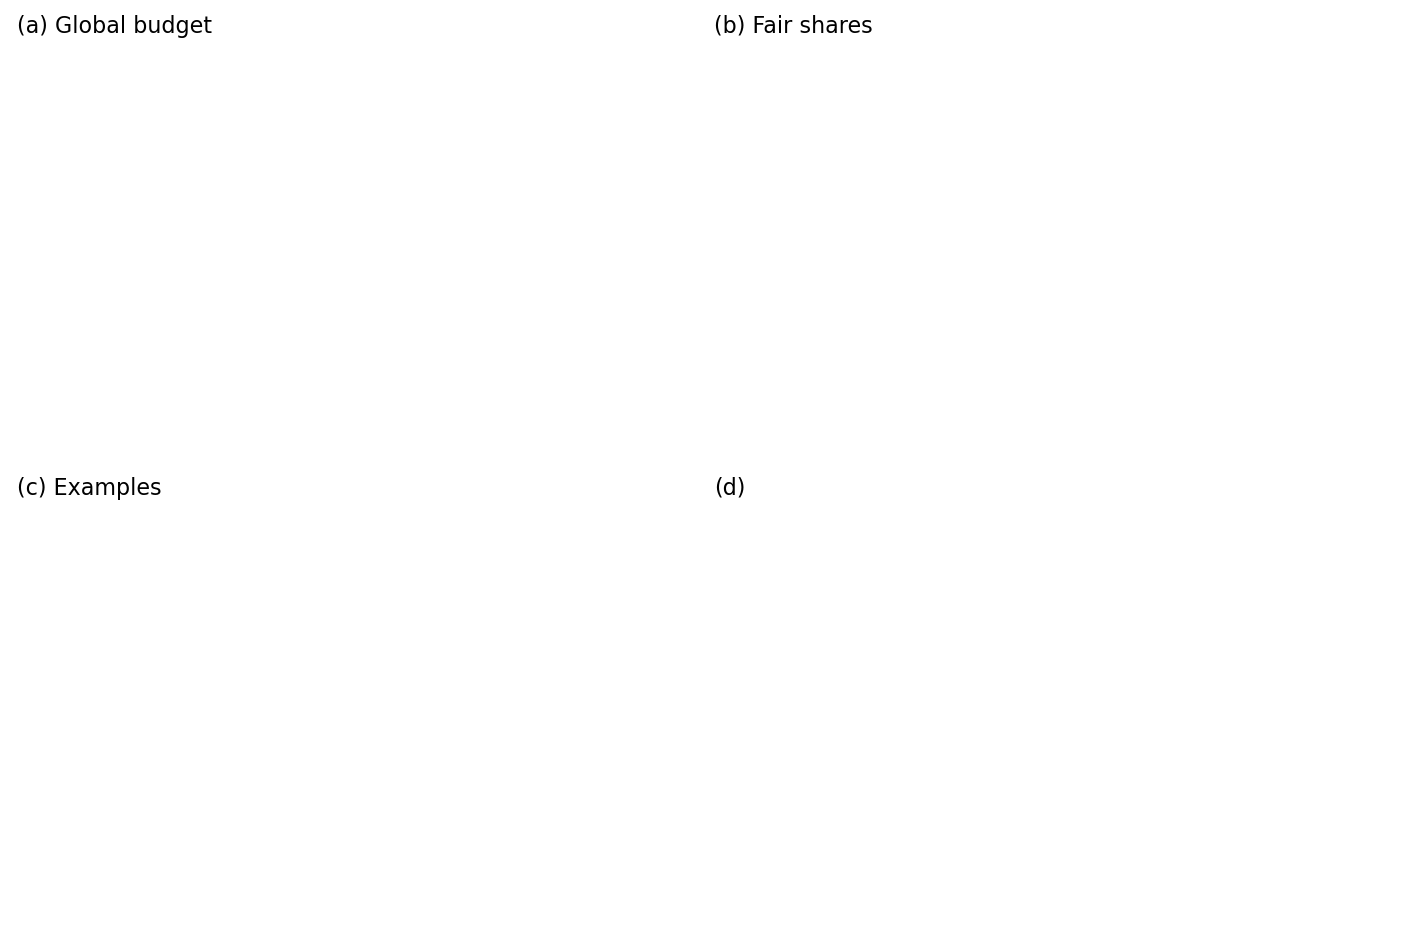

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12), gridspec_kw={'wspace': 0, 'hspace': 0})

for ax_i, ax in enumerate([ax1, ax2, ax3, ax4]):
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.text(
        0.01, 0.99, ["(a) Global budget",
                     "(b) Fair shares",
                     "(c) Examples",
                     "(d)"][ax_i],
        transform=ax.transAxes,  # Use Axes coordinates (0=left, 1=right for x; 0=bottom, 1=top for y)
        fontsize=16,
        verticalalignment='top', 
        horizontalalignment='left'
    )

In [11]:
float(xr_dataread.Budget.sel(Temperature=1.6, Risk=0.5, NonCO2red=0.17))

354.84440474575604

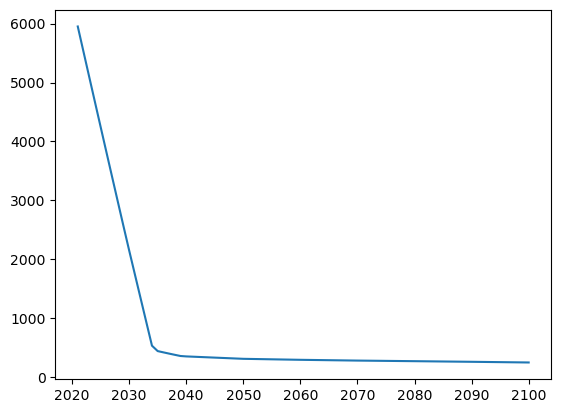

In [12]:
plt.plot(xr_allocs['USA'].Time, xr_allocs['USA'].sel(**settings_specific).PCB_lin)

[]

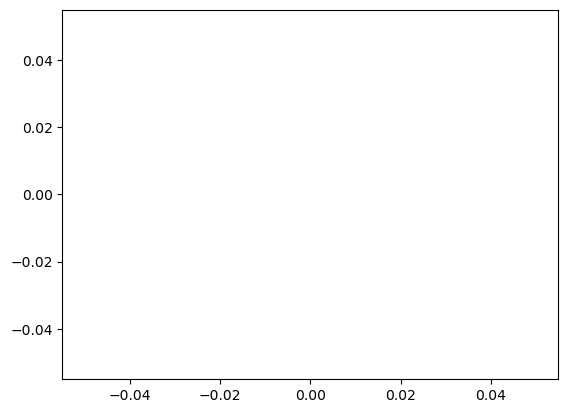

In [13]:
plt.plot()

## Default settings

In [14]:
settings_global = {'Temperature': 1.6,
                   'Risk': 0.5,
                   'NegEmis': 0.5,
                   'NonCO2red': 0.5,
                   'Timing': "Immediate"}
settings_globalt = {'Risk': 0.50,
                   'NegEmis': 0.5,
                   'NonCO2red': 0.5,
                   'Timing': "Immediate"}
settings_globaltraj = {'NegEmis': 0.5,
                   'NonCO2red': 0.5,
                   'Timing': "Immediate"}
settings_params = {'Convergence_year': 2050,
                   'Scenario': 'SSP2',
                   'Discount_factor': 0,
                   'Historical_startyear': 1990,
                   'Capability_threshold': "Th",
                   'RCI_weight': "Half"}
settings_params_range = {'Convergence_year': [2050, 2080]}
alloc_dimensions = ['Scenario', 'Convergence_year', 'Discount_factor', 'Historical_startyear', 'Capability_threshold', 'RCI_weight']

#rules = ['GF', 'PC', 'PCC', 'PCB', 'AP', 'ECPC', 'GDR']
#rulecolors = ['sienna', 'purple', 'goldenrod', 'mediumvioletred', 'forestgreen', 'tomato', 'steelblue']
#rulenames = ['Grandfathering', '(Immediate) per capita', 'Per capita convergence', 'Per capita via budget', 'Ability to pay', 'Equal Cumulative per capita', 'Greenhouse Development Rights']
rules_short = ['PCC', 'AP', 'ECPC']
rulecols_short = ['steelblue', 'goldenrod', 'purple']
rulenames_short = ['Per capita convergence', 'Ability to pay', 'Equal Cumulative per capita']
countries_highlighted = ['USA', 'EU', 'IND', 'CHN', 'NGA', 'BRA']

## Plot

In [15]:
lw = 3
risk = 0.5
time_hist = np.arange(1990, params['start_year_analysis']+1)
time_fut = np.arange(params['start_year_analysis'], 2101)
whichtemps = [1.5, 1.6, 1.8, 2.0]
maxtime = 2052
mintime= 2005

NameError: name 'params' is not defined

In [239]:
cols_ctys = np.array(rulecols_short)[np.array(xr_alloc_2030.sel(Temperature=1.6, **settings_globalt, **settings_params)[rules_short].to_array()).argmax(axis=0)]

Traces for panel (a)

In [240]:
traces_panel_a = []

# Historical emissions
traces_panel_a.append(go.Scatter(x=time_hist,
                                 y=xr_dataread.sel(Time=time_hist, Region='EARTH').GHG_hist/1e3,
                                 name='Historical emissions',
                                 line={'color': 'black', 'width': lw}, mode='lines', legend='legend1', showlegend=True))

# Baseline emissions
for var_i in range(3):
    var = [xr_dataread.sel(Time=np.arange(params['start_year_analysis'], 2101), Region='EARTH').GHG_base_incl.min(dim='Scenario'),
           xr_dataread.sel(Time=np.arange(params['start_year_analysis'], 2101), Region='EARTH').GHG_base_incl.max(dim='Scenario'),
           xr_dataread.sel(Time=np.arange(params['start_year_analysis'], 2101), Region='EARTH').GHG_base_incl.mean(dim='Scenario')][var_i]
    traces_panel_a.append(go.Scatter(x=time_fut,
                                    y=var/1e3,
                                    name='Baseline emissions',
                                    legend='legend1', 
                                    fill = [None, 'tonexty', None][var_i],
                                    line={'color': 'grey', 'width': [0, 0, lw][var_i]}, mode='lines',
                                    showlegend=[False, False, True][var_i]))

# Global emissions pathways
tempcols = ['goldenrod', 'tomato', 'darkred']
for temp_i, temp in enumerate(whichtemps):
       col = plt.cm.Reds(0.30+temp_i/len(whichtemps))
       col2 = plt.cm.Reds(0.10+temp_i/len(whichtemps))
       for var_i in range(2):
              var = [xr_dataread.sel(Time=np.arange(params['start_year_analysis'], 2101), Temperature=temp, Risk=[0.33, 0.5]).GHG_globe.min(dim=['NegEmis', 'NonCO2red', 'Timing', 'Risk']),
                     xr_dataread.sel(Time=np.arange(params['start_year_analysis'], 2101), Temperature=temp, Risk=[0.33, 0.5]).GHG_globe.max(dim=['NegEmis', 'NonCO2red', 'Timing', 'Risk']),
                     xr_dataread.sel(Time=np.arange(params['start_year_analysis'], 2101), Temperature=temp, **settings_globalt).GHG_globe][var_i]
              traces_panel_a.append(go.Scatter(x=time_fut,
                                                 y=var/1e3,
                                                 name="Global "+str(temp)+"&deg;C (50%)",
                                                 fill = [None, 'tonexty', None][var_i],
                                                 legend='legend1',
                                                 fillcolor='rgba('+str(col[0])+','+str(col[1])+','+str(col[2])+', 0.05)',
                                                 line={'color': 'rgba('+str(col2[0])+','+str(col2[1])+','+str(col2[2])+', 0.15)', 'width': [0, 0, lw][var_i]}, mode='lines',
                                                 showlegend=[False, False, False][var_i]))
for temp_i, temp in enumerate(whichtemps):
       col = plt.cm.Reds(0.30+temp_i/len(whichtemps))
       col2 = plt.cm.Reds(0.30+temp_i/len(whichtemps))
       var_i = 2
       var = [xr_dataread.sel(Time=np.arange(params['start_year_analysis'], 2101), Temperature=temp, Risk=[0.33, 0.5]).GHG_globe.min(dim=['NegEmis', 'NonCO2red', 'Timing', 'Risk']),
              xr_dataread.sel(Time=np.arange(params['start_year_analysis'], 2101), Temperature=temp, Risk=[0.33, 0.5]).GHG_globe.min(dim=['NegEmis', 'NonCO2red', 'Timing', 'Risk']),
              xr_dataread.sel(Time=np.arange(params['start_year_analysis'], 2101), Temperature=temp, **settings_globalt).GHG_globe][var_i]
       traces_panel_a.append(go.Scatter(x=time_fut,
                                          y=var/1e3,
                                          name=str(temp)+"&deg;C (50%)",
                                          fill = [None, 'tonexty', None][var_i],
                                          legend='legend1',
                                          line={'color': 'rgb('+str(col2[0])+','+str(col2[1])+','+str(col2[2])+')', 'width': [0, 0, lw][var_i]}, mode='lines',
                                          showlegend=True))

Traces for panel (b)

In [241]:
traces_panel_b = []
for cty_i, cty in enumerate(np.array(xr_alloc_2030.Region)):
    pop = float(xr_dataread.Population.sel(Scenario='SSP2', Region=cty, Time=params['start_year_analysis']))
    if not np.isnan(pop):
        if pop > 1e-1:
            if cty in all_countries_iso:
                popn = np.sqrt(pop / np.nanmax(xr_dataread.Population.sel(Scenario='SSP2', Region=all_countries_iso, Time=params['start_year_analysis'])))
                traces_panel_b.append(go.Scatter(x=[xr_dataread.GDP.sel(Scenario='SSP2', Region=cty, Time=params['start_year_analysis'])*1e9/pop/1e6],
                                        y=[xr_dataread.GHG_hist.sel(Time=np.arange(1950, params['start_year_analysis']), Region=cty).sum(dim='Time')/pop/1e6*1e3],
                                        mode='markers',
                                        text=cty,
                                        textfont={'size': popn * 32+3, 'color': 'black'},
                                        marker={'size': popn * 60+8, 'color': cols_ctys[cty_i], 'opacity': 0.4},
                                        showlegend=False))
for cty_i, cty in enumerate(np.array(xr_alloc_2030.Region)):
    pop = float(xr_dataread.Population.sel(Scenario='SSP2', Region=cty, Time=params['start_year_analysis']))
    if not np.isnan(pop):
        if pop > 1e-1:
            if cty in all_countries_iso:
                popn = np.sqrt(pop / np.nanmax(xr_dataread.Population.sel(Scenario='SSP2', Region=all_countries_iso, Time=params['start_year_analysis'])))
                if cty in ['USA']:
                    traces_panel_b.append(go.Scatter(x=[xr_dataread.GDP.sel(Scenario='SSP2', Region=cty, Time=params['start_year_analysis'])*1e9/pop/1e6],
                                            y=[xr_dataread.GHG_hist.sel(Time=np.arange(1950, params['start_year_analysis']), Region=cty).sum(dim='Time')/pop/1e6*1e3],
                                            mode='text',
                                            text=cty,
                                            textfont={'size': popn * 32+3, 'color': 'black'},
                                            marker={'size': popn * 60+8, 'color': cols_ctys[cty_i], 'opacity': 0.7},
                                            showlegend=False))
                if cty in ['IND', 'CHN', 'RWA', 'BRA', 'ZAF', 'FRA', 'SOM', 'YEM', 'ZMB', 'DEU', 'NGA']:
                    traces_panel_b.append(go.Scatter(x=[xr_dataread.GDP.sel(Scenario='SSP2', Region=cty, Time=params['start_year_analysis'])*1e9/pop/1e6],
                                            y=[xr_dataread.GHG_hist.sel(Time=np.arange(1950, params['start_year_analysis']), Region=cty).sum(dim='Time')/pop/1e6*1e3],
                                            mode='text',
                                            text=all_countries_names[all_countries_iso == cty][0],
                                            textfont={'size': popn * 20+15, 'color': 'black'},
                                            marker={'size': popn * 60+8, 'color': cols_ctys[cty_i], 'opacity': 0.7},
                                            showlegend=False))

Traces for panels (c)-(h)

In [242]:
traces_panels_ch = []
for cty_i, cty in enumerate(countries_highlighted):

    if cty == 'USA': sl = True
    else: sl = False

    emis_2021 = float(xr_dataread.GHG_hist.sel(Time=2021, Region=cty)/1e3)
    traces_panel_i = []
    traces_panel_j = []

    # Historical emissions
    traces_panel_i.append(go.Scatter(x=np.arange(mintime, params['start_year_analysis']+1),
                                     y=xr_dataread.sel(Time=np.arange(mintime, params['start_year_analysis']+1), Region=cty).GHG_hist/1e3/emis_2021,
                                     name='Historical emissions', line={'color': 'black', 'width': lw}, mode='lines', showlegend=False))

    # Baseline emissions
    for var_i in range(3):
        var = [xr_dataread.sel(Time=np.arange(params['start_year_analysis'], maxtime), Region=cty).GHG_base_incl.min(dim='Scenario'),
                xr_dataread.sel(Time=np.arange(params['start_year_analysis'], maxtime), Region=cty).GHG_base_incl.max(dim='Scenario'),
                xr_dataread.sel(Time=np.arange(params['start_year_analysis'], maxtime), Region=cty).GHG_base_incl.mean(dim='Scenario')][var_i]
        traces_panel_i.append(go.Scatter(x=time_fut,
                                        y=var/1e3/emis_2021,
                                        fill = [None, 'tonexty', None][var_i],
                                        line={'color': 'grey', 'width': [0, 0, lw][var_i]}, mode='lines',
                                        showlegend=False))
    vals = np.array(xr_dataread.sel(Time=np.arange(params['start_year_analysis'], maxtime), Region=cty).GHG_base_incl.sel(Time=2030))
    vals_default = float(xr_dataread.sel(Time=np.arange(params['start_year_analysis'], maxtime), Region=cty, Scenario='SSP2').GHG_base_incl.sel(Time=2030))
    # traces_panel_j.append(go.Violin(x=['Base']*len(vals),
    #                                 y=vals/1e3/emis_2021,
    #                                 showlegend=False,
    #                                 width=1.5,
    #                                 points=False,
    #                                 line={'width': 0},
    #                                 line_color='grey')
    #             )
    
    traces_panel_j.append(go.Box(x=['Base']*len(vals),
                                    y=vals/1e3/emis_2021,
                                    legend='legend2',
                                    #fillcolor = 'grey',
                                    showlegend=sl,
                                    width=0.8,
                                    name='Baseline',
                                    boxpoints=False,
                                    #pointpos = 0,
                                    #points=False,
                                    line={'width': 1},
                                    line_color='grey')
                )
    traces_panel_j.append(go.Scatter(x=['Base'],
                                    y=[vals_default/1e3/emis_2021],
                                    mode='markers',
                                    showlegend=False,
                                    marker_symbol = 'diamond-wide',
                                    marker=dict(size=15),
                                    line={'width': 2},
                                    line_color='grey')
                )

    # NDC
    vals = [np.nanmin(np.array(xr_dataread.sel(Region=cty).GHG_ndc)), np.nanmax(np.array(xr_dataread.sel(Region=cty).GHG_ndc))]
    traces_panel_i.append(go.Scatter(x=[2030, 2030],
                                    y=np.array(vals)/1e3/emis_2021,
                                    name = 'NDC',
                                    marker_symbol='diamond-wide',
                                    marker_size=20,
                                    line={'color': 'forestgreen', 'width': 5}, mode='lines+markers',
                                    legend='legend2',
                                    showlegend=sl))
    traces_panel_j.append(go.Scatter(x=['NDC', 'NDC'],
                                    marker_symbol='diamond-wide',
                                    y=np.array(vals)/1e3/emis_2021,
                                    marker_size=20,
                                    line={'color': 'forestgreen', 'width': 5}, mode='lines+markers',
                                    showlegend=False))

    # Allocation
    trajs = [traj_15.sel(Time=np.arange(params['start_year_analysis'], maxtime), Region=cty, **settings_globaltraj, **settings_params_range).min(dim=alloc_dimensions),
                traj_15.sel(Time=np.arange(params['start_year_analysis'], maxtime), Region=cty, **settings_globaltraj, **settings_params_range).max(dim=alloc_dimensions),
                traj_15.sel(Time=np.arange(params['start_year_analysis'], maxtime), Region=cty, **settings_globaltraj, **settings_params)]
    for alloc_i, alloc in enumerate(rules_short):
        col = colors.to_rgba(rulecols_short[alloc_i])
        for var_i in range(2):
            var = trajs[var_i][alloc]
            traces_panel_i.append(go.Scatter(x=time_fut,
                                            y=var/1e3/emis_2021,
                                            fill = [None, 'tonexty', None][var_i],
                                            fillcolor = 'rgba('+str(col[0])+','+str(col[1])+','+str(col[2])+', 0.25)',
                                            line={'color':rulecols_short[alloc_i], 'width': [0, 0, lw][var_i]}, mode='lines',
                                            showlegend=False))
        vals = np.array(traj_15.sel(Region=cty, Time=2030, **settings_globaltraj, **settings_params_range)[alloc]).flatten()
        
        traces_panel_j.append(go.Box(x=[alloc]*len(vals),
                                        y=vals/1e3/emis_2021,
                                        legend='legend2',
                                        fillcolor = 'rgba('+str(col[0])+','+str(col[1])+','+str(col[2])+', 0.25)',
                                        showlegend=sl,
                                        width=0.8,
                                        name=rulenames_short[alloc_i]+"<br>"+['(Equality)', '(Capability)', '(Responsibility)'][alloc_i],
                                        boxpoints=False,
                                        #pointpos = 0,
                                        #points=False,
                                        line={'width': 1},
                                        line_color=rulecols_short[alloc_i])
                    )
                    

        # traces_panel_j.append(go.Violin(x=[alloc]*len(vals),
        #                                 y=vals/1e3/emis_2021,
        #                             legend='legend2',
        #                                 fillcolor = 'rgba('+str(col[0])+','+str(col[1])+','+str(col[2])+', 0.25)',
        #                                 showlegend=sl,
        #                                 width=1.5,
        #                                 name=rulenames_short[alloc_i],
        #                                 points="all",
        #                                 line={'width': 0},
        #                                 line_color=rulecols_short[alloc_i])
        #             )
                    
    # NDC
    vals = [np.nanmin(np.array(xr_dataread.sel(Region=cty).GHG_ndc)), np.nanmax(np.array(xr_dataread.sel(Region=cty).GHG_ndc))]
    traces_panel_i.append(go.Scatter(x=[2030, 2030],
                                    y=np.array(vals)/1e3/emis_2021,
                                    line={'color': 'forestgreen', 'width': 5}, mode='lines+markers',
                                    marker_symbol='diamond-wide',
                                    marker_size=20,
                                    showlegend=False))
    traces_panel_j.append(go.Scatter(x=['NDC', 'NDC'],
                                    y=np.array(vals)/1e3/emis_2021,
                                    marker_symbol='diamond-wide',
                                    line={'color': 'forestgreen', 'width': 5}, mode='lines+markers',
                                    marker_size=20,
                                    showlegend=False))
    
    traces_panels_ch.append([traces_panel_i, traces_panel_j])

traces_panels_ch_2 = []
for cty_i, cty in enumerate(countries_highlighted):
    emis_2021 = float(xr_dataread.GHG_hist.sel(Time=2021, Region=cty)/1e3)
    traces_panel_i = []
    traces_panel_j = []
    # Allocation
    trajs = traj_15.sel(Time=np.arange(params['start_year_analysis'], maxtime), Region=cty, **settings_globaltraj, **settings_params)
    for alloc_i, alloc in enumerate(rules_short):
        trajs2 = float(traj_15.sel(Region=cty, Time=2030, **settings_globaltraj, **settings_params)[alloc])
        var = trajs[alloc]
        traces_panel_i.append(go.Scatter(x=time_fut,
                                        y=var/1e3/emis_2021,
                                        fill = None,
                                        line={'color': rulecols_short[alloc_i], 'width': lw}, mode='lines',
                                        showlegend=False))
        traces_panel_j.append(go.Scatter(x=[alloc],
                                        y=[trajs2/1e3/emis_2021],
                                        mode='markers',
                                        marker_symbol = 'diamond-wide',
                                        showlegend=False,
                                        marker=dict(size=20),
                                        line={'width': 2},
                                        line_color=rulecols_short[alloc_i])
                    )
    
    traces_panels_ch_2.append([traces_panel_i, traces_panel_j])

Full plot

In [243]:
ghg_2015 = float(xr_dataread.sel(Region='EARTH', Time=2015).GHG_hist)/1e3
ghg_2021 = float(xr_dataread.sel(Region='EARTH', Time=2021).GHG_hist)/1e3
ghg_base = float(xr_dataread.sel(Region='EARTH', Time=2030).GHG_base_incl.mean(dim='Scenario'))/1e3

In [244]:
fig = make_subplots(rows=4, cols=6,
                    specs=[[{'colspan': 4, 'rowspan': 2}, {}, {}, {}, {'colspan': 2, 'rowspan': 2}, {}],
                           [{}, {}, {}, {}, {}, {}],
                           [{}, {}, {}, {}, {}, {}],
                           [{}, {}, {}, {}, {}, {}]],
                    horizontal_spacing = 0.02, vertical_spacing=0.06)

# Panel (a)
for t_i, t in enumerate(traces_panel_a):
     fig.add_trace(t, 1, 1)
fig.add_trace(go.Scatter(x=[1990, 2100], y=[0, 0], line={'color': 'black', 'width': lw/2, 'dash': 'dash'}, mode='lines', showlegend=False), 1, 1)
fig.add_trace(go.Scatter(x=[2030, 2030], y=[-10, 73], line={'color': 'black', 'width': lw/2, 'dash': 'dash'}, mode='lines', showlegend=False), 1, 1)
fig.add_trace(go.Scatter(x=[2015, 2015], y=[52.47, 57], line={'color': 'black', 'width': lw/2}, mode='lines', showlegend=False), 1, 1)
#fig.add_trace(go.Scatter(x=2015, y=55, text='2015', showarrow=False, mode='text', font=dict(color='black', size=16)), 1, 1)

fig.add_trace(go.Scatter(x=[2015], y=[58], text='<b>2015</b>:<br>'+str(np.round(float(xr_dataread.GHG_hist.sel(Region='EARTH', Time=2015))/1e3, 1))+' Gt CO<sub>2</sub>e<br> ', mode='text', textfont=dict(color='black', size=18), showlegend=False), 1, 1)
fig.add_trace(go.Scatter(x=[2030], y=[76], text='<b>2030</b>', mode='text', textfont=dict(color='black', size=18), showlegend=False), 1, 1)
fig.add_trace(go.Scatter(x=[2030], y=[ghg_base], text='           +'+str(int(np.round((ghg_base - ghg_2015)/ghg_2015*100)))+'%', mode='markers+text', marker={'color':'black', 'size': 10}, textfont=dict(color='black', size=18), showlegend=False), 1, 1)
for temp_i, temp in enumerate(whichtemps):
       vari = float(xr_dataread.sel(Time=2030, Temperature=temp, **settings_globalt).GHG_globe/1e3)
       var = (ghg_2015-vari)/ghg_2015
       fig.add_trace(go.Scatter(x=[2030], y=[vari], text='           -'+str(int(np.round(var*100,0)))+'%', mode='markers+text', marker={'color':'black', 'size': 10}, textfont=dict(color='black', size=18), showlegend=False), 1, 1)


# Panel (b)
for t_i, t in enumerate(traces_panel_b):
     fig.add_trace(t, 1, 5)
  
# Panel (c)-(h)
for a_i, a in enumerate(traces_panels_ch):
     for b_i, traces in enumerate(a):
          for t_i, t in enumerate(traces):
               fig.add_trace(t, [3, 4][b_i], [1, 2, 3, 4, 5, 6][a_i])
for a_i, a in enumerate(traces_panels_ch_2):
     for b_i, traces in enumerate(a):
          for t_i, t in enumerate(traces):
               fig.add_trace(t, [3, 4][b_i], [1, 2, 3, 4, 5, 6][a_i])

# Add horizontal line at NDCs in row 4
for col in range(1, 7):
     y0 = float(np.nanmin(np.array(xr_dataread.sel(Region=countries_highlighted[col-1]).GHG_ndc)) / xr_dataread.sel(Region=countries_highlighted[col-1]).GHG_hist.sel(Time=2021))
     y1 = float(np.nanmax(np.array(xr_dataread.sel(Region=countries_highlighted[col-1]).GHG_ndc)) / xr_dataread.sel(Region=countries_highlighted[col-1]).GHG_hist.sel(Time=2021))
     fig.add_shape(
          type="line",
          xref="x" +str(col+18)+" domain",  # Use 'paper' to reference the entire plot width
          x0=0, x1=1,  # Span from the left (0) to the right (1) of the plot
          yref="y"+str(col+18),  # Reference the y-axis for the position
          y0=y0, y1=y0,  # The y value is constant for a horizontal line
          line=dict(color="forestgreen", width=lw, dash="dot"),  # Line style
     )
     fig.add_shape(
          type="line",
          xref="x" +str(col+18)+" domain",  # Use 'paper' to reference the entire plot width
          x0=0, x1=1,  # Span from the left (0) to the right (1) of the plot
          yref="y"+str(col+18),  # Reference the y-axis for the position
          y0=y1, y1=y1,  # The y value is constant for a horizontal line
          line=dict(color="forestgreen", width=lw, dash="dot"),  # Line style
     )
     # fig.add_trace(go.Scatter(x=['Base', 'ECPC'], y=[y0, y0], line={'color': 'forestgreen', 'width': lw, 'dash': 'dash'}, mode='lines', showlegend=False), 4, col)
     # fig.add_trace(go.Scatter(x=['Base', 'ECPC'], y=[y0, y0], line={'color': 'forestgreen', 'width': lw, 'dash': 'dash'}, mode='lines', showlegend=False), 4, col)

for row_i, row in enumerate([3, 4]):
     for col in [1, 2, 3, 4, 5, 6]:
          # if col == 1: fig.update_yaxes(row=row, col=col, range=[[-2, -2][row_i], [6, 6][row_i]])
          # else: fig.update_yaxes(row=row, col=col, visible=False, range=[[-2, -2][row_i], [6, 6][row_i]])
          if col == 1: fig.update_yaxes(row=row, col=col, range=[[-0.5, -0.5][row_i], [2.5, 2.5][row_i]])
          else: fig.update_yaxes(row=row, col=col, visible=False, range=[[-0.5, -0.5][row_i], [2.5, 2.5][row_i]])

fs = 25
fig.update_xaxes(title_text="GDP per capita in 2021 [USD]", type="log", row=1, col=5, range=[2.4, 5])
fig.update_yaxes(type="log", row=1, col=5, range=[-1.8, 0.5])
fig.update_yaxes(title_text="Global GHG emissions [Gt CO<sub>2</sub>e/yr]", row=1, col=1, range=[-10, 90], title_font_size=18)
fig['layout'].update(
    annotations=[dict(x=0.01, y=1.0, text='<b>(a) Global GHG emission trajectories</b>', xref='paper', yref='paper', showarrow=False, font=dict(color='black', size=fs)),
                 dict(x=0.69, y=1.0, text='<b>(b) Highest allocations</b>', xref='paper', yref='paper', xanchor='left', showarrow=False, font=dict(color='black', size=fs)),
                 dict(x=0.69, y=0.97, text='in 2030 for a 1.6&deg;C pathway', xref='paper', yref='paper', xanchor='left', showarrow=False, font=dict(color='black', size=fs*0.7)),

               #   dict(x=0.72, y=0.94, text='Equality (PCC)', xref='paper', yref='paper', xanchor='left', showarrow=False, font=dict(color='steelblue', size=fs*0.7)),
               #   dict(x=0.72, y=0.92, text='Capability (AP)', xref='paper', yref='paper', xanchor='left', showarrow=False, font=dict(color='goldenrod', size=fs*0.7)),
               #   dict(x=0.72, y=0.9, text='Responsibility (ECPC)', xref='paper', yref='paper', xanchor='left', showarrow=False, font=dict(color='purple', size=fs*0.7)),

                 dict(x=0.71, y=0.94, text='GHG emissions 1950-2021 per capita [kt CO<sub>2</sub>e]', xref='paper', yref='paper', showarrow=False, textangle=-90, font=dict(color='black',  size=18)),

                 dict(x=0.005, y=0.48, text='<b>(c) Allocations over time</b>', xref='paper', yref='paper', showarrow=False, font=dict(color='black', size=fs)),
                 dict(x=0.005, y=0.20, text='<b>(d) Allocations in 2030</b>', xref='paper', yref='paper', showarrow=False, font=dict(color='black', size=fs)),
                 
                 dict(x=0.005, y=0.45, text='United States', xref='paper', yref='paper', showarrow=False, font=dict(color='black', size=fs-4)),
                 dict(x=0.17, y=0.45, text='European Union', xref='paper', yref='paper', showarrow=False, font=dict(color='black', size=fs-4)),
                 dict(x=0.36, y=0.45, text='India', xref='paper', yref='paper', showarrow=False, font=dict(color='black', size=fs-4)),
                 dict(x=0.54, y=0.45, text='China', xref='paper', yref='paper', showarrow=False, font=dict(color='black', size=fs-4)),
                 dict(x=0.74, y=0.45, text='Nigeria', xref='paper', yref='paper', showarrow=False, font=dict(color='black', size=fs-4)),
                 dict(x=0.90, y=0.45, text='Brazil', xref='paper', yref='paper', showarrow=False, font=dict(color='black', size=fs-4)),

                 dict(x=-0.05, y=-0.01, text='GHG emissions allocations w.r.t. 2021 (1.6&deg;C, 50%)', xref='paper', yref='paper', textangle=-90, showarrow=False, font=dict(color='black', size=fs*0.7)),
                 dict(x=-0.035, y=0.36, text='Over time', xref='paper', yref='paper', textangle=-90, showarrow=False, font=dict(color='black', size=fs*0.7)),
                 dict(x=-0.035, y=0.08, text='In 2030', xref='paper', yref='paper', textangle=-90, showarrow=False, font=dict(color='black', size=fs*0.7)),
])
fig.add_shape(
    type="line",
    xref="paper",  # Use 'paper' to reference the entire plot width
    x0=0, x1=1,  # Span from the left (0) to the right (1) of the plot
    yref="y13",  # Reference the y-axis for the position
    y0=0, y1=0,  # The y value is constant for a horizontal line
    line=dict(color="grey", width=2, dash="dash"),  # Line style
)
fig.add_shape(
    type="line",
    xref="paper",  # Use 'paper' to reference the entire plot width
    x0=0, x1=1,  # Span from the left (0) to the right (1) of the plot
    yref="y19",  # Reference the y-axis for the position
    y0=0, y1=0,  # The y value is constant for a horizontal line
    line=dict(color="grey", width=2, dash="dash"),  # Line style
)

fig.update_yaxes(ticks="inside")
fig.update_xaxes(ticks="inside")
fig.update_layout(height=1300, width=1600, template='simple_white')
fig.update_layout(legend1=dict(
    yanchor="top",
    y=0.74,
    xanchor="left",
    #orientation="h",
    x=0.01,
    font=dict( 
        size=16,
        color="black"
    ),
), legend2=dict(
    yanchor="top",
    y=-0.03,
    xanchor="center",
    orientation="h",
    x=0.5,
    font=dict( 
        size=16,
        color="black"
    ),
),
    font=dict(
        size=16,
    ))

In [20]:
# def html_w(typ):
#     return '<html> '+typ+' <p style="font-family: Arial">'

# with open('K:/Code/EffortSharing/Figures/Paper_FairShares/Figure_1.html', 'a') as f:
#     f.write(html_w('<h1>')+'Indicators</p></h1>')
#     f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))

In [245]:
import kaleido

In [246]:
fig.write_image("K:/Code/effort-sharing/Figures/Paper_FairShares/V2/Figure_1.png", scale=3, engine='kaleido')